In [4]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
from matplotlib import pyplot as plt
import time


# Dataset

In [5]:
from main import noisy_circle, draw_circle, iou
from torchvision.transforms import Compose, ToTensor, Normalize


def normalize_range(img):
    '''
    Normalizes range of input image
    @param img: input image
    @return img: image in range [0,255]
    '''
    img = 255*(img - np.min(img))/(np.max(img) - np.min(img))
    img = img.astype("uint8")
    return img

def clean_circle(size, params):
    '''
    Creates an image of the clean circle for model training
    '''
    row, col, rad = params
    img = np.zeros((size, size), dtype=np.float)
    img = draw_circle(img, row, col, rad)
    return img
    
class NoisyCircleDataset(Dataset):
    def __init__(self, N, transforms=None, preprocess=True):
        super(NoisyCircleDataset, self).__init__()
        self.transforms = transforms
        self.preprocess = preprocess
        self.data = self.build_dataset(N, 200)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample
    
    def denoise_preprocess(self, img):
        '''
        Denoises image by using a combination of smoothing filters
        @param img:  noisy input image
        @return denoised_img: denoised image
        '''
        denoised_img = np.clip(img,165,255)

        #--- Preprocess params 2 ---#
        denoised_img = cv2.GaussianBlur(denoised_img, (9,9), 3)
        denoised_img = cv2.bilateralFilter(denoised_img, 3, 70, 70) 

        #--- Original filter values ---#
        #denoised_img = cv2.GaussianBlur(denoised_img, (9,9), 2.5, cv2.BORDER_REPLICATE)
        #denoised_img = cv2.bilateralFilter(denoised_img, 3, 70, 70) 
        return denoised_img
    
    def build_dataset(self, N, size=200):
        dataset = []
        for i in range(N):
            params, noisy = noisy_circle(size, 50, 2)
            clean = clean_circle(size, params)
            
            # Normalize images from [0,1] to [0,255]
            noisy = normalize_range(noisy)
            clean = normalize_range(clean)
            
            # Preprocess noisy image using smoothing filters
            if self.preprocess:
                noisy = self.denoise_preprocess(noisy)
                
            if self.transforms is not None:
                noisy = self.transforms(noisy)
                clean = self.transforms(clean)
                
            tmp = {}
            tmp['params'] = np.array(params)
            tmp['noisy'] = noisy
            tmp['clean'] = clean
            dataset.append(tmp)
        return dataset
    
    
    


def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = (image + 1) / 2
    image = np.clip(image,0,1)
    h = ax.imshow(image, cmap='gray')
    return h

# train_set = NoisyCircleDataset(10, transforms, preprocess=True)
# x = train_set.__getitem__(8)
# figs, axs = plt.subplots(1, 2, figsize=(12,8))
# noisy_img = myimshow(x['clean'][0], axs[0])
# clean_img = myimshow(x['noisy'][0], axs[1])

# Circle Detection 

In [1]:
def detect_circle(img):
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 100,
                  param1=30,
                  param2=15,
                  minRadius=0,
                  maxRadius=0)
    if circles is not None:
        params = circles[0][0]
        col, row, rad = int(params[0]), int(params[1]), int(params[2])
        return (row, col, rad)
    else:
        return (1,1,1)


# Image Preprocessing 

Sample 0


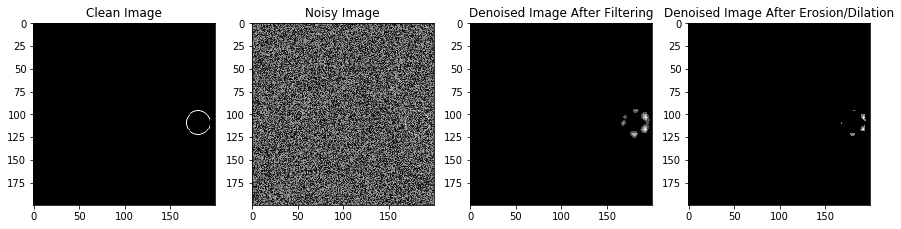

Groundtruth parameters [109 181  13]
Predictions after denoising (1, 1, 1)
Predictions after erosion/dilation (1, 1, 1)
Sample 5


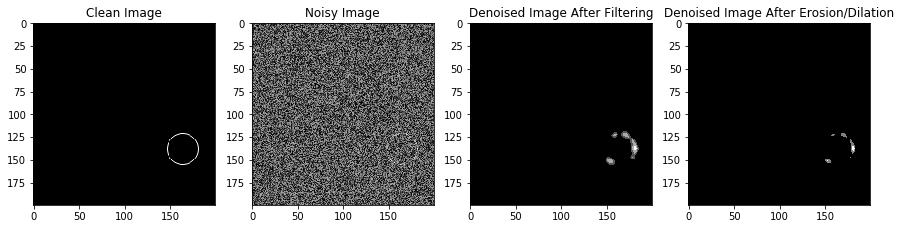

Groundtruth parameters [138 164  17]
Predictions after denoising (1, 1, 1)
Predictions after erosion/dilation (1, 1, 1)
Sample 10


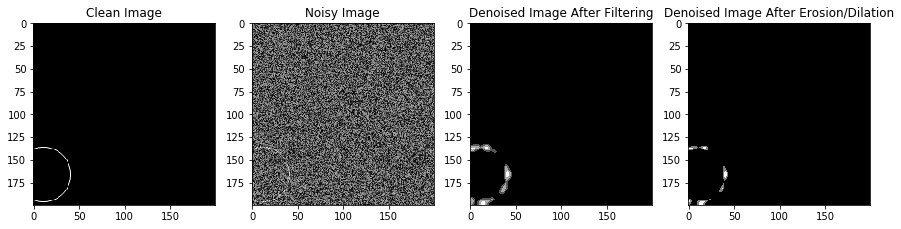

Groundtruth parameters [166  11  30]
Predictions after denoising (1, 1, 1)
Predictions after erosion/dilation (1, 1, 1)
Sample 15


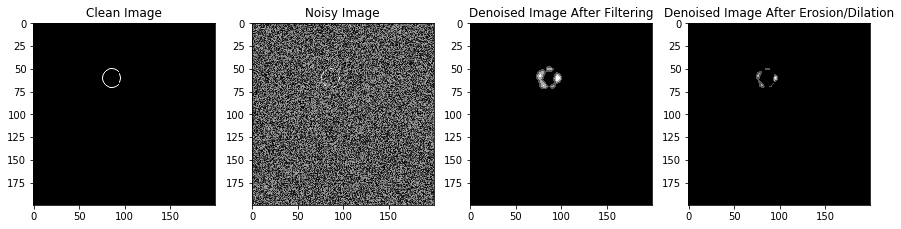

Groundtruth parameters [60 86 10]
Predictions after denoising (1, 1, 1)
Predictions after erosion/dilation (1, 1, 1)
AP@0.7 = 0.0


In [75]:
#--- Testing out which filters and parameters work best for preprocessing ---# 

dataset = NoisyCircleDataset(20, preprocess=False)

results = []
for sample in range(len(dataset)):
    clean_img = dataset[sample]['clean']
    noisy_img = dataset[sample]['noisy']

    denoised_img = np.clip(noisy_img,169,255)
    denoised_img = cv2.GaussianBlur(denoised_img, (13,13), 3)
    denoised_img = cv2.bilateralFilter(denoised_img, 3, 70, 70) 



    kernel1 = np.ones((3,3),np.uint8)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    morph = denoised_img   
    morph = cv2.erode(morph,kernel2,iterations = 2)
#     morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel1)


    if sample%5 == 0:
        print('Sample {}'.format(sample))
        fig, axs = plt.subplots(1,4,figsize=(15, 8))
        axs[0].set_title('Clean Image')
        axs[0].imshow(clean_img, cmap='gray')

        axs[1].set_title('Noisy Image')
        axs[1].imshow(noisy_img, cmap='gray')

        axs[2].set_title('Denoised Image After Filtering')
        axs[2].imshow(denoised_img, cmap='gray')

        axs[3].set_title('Denoised Image After Erosion/Dilation')
        axs[3].imshow(morph, cmap='gray')
        plt.show()

        print('Groundtruth parameters', dataset[sample]['params'])
        predictions = detect_circle(denoised_img)
        print('Predictions after denoising', predictions)
        predictions = detect_circle(morph)
        print('Predictions after erosion/dilation', predictions)
    
    predicted = detect_circle(denoised_img)
    groundtruth = detect_circle(clean_img)
    results.append(iou(groundtruth, predicted))

results = np.array(results)
print('AP@0.7 =', (results > 0.7).mean())

# Image Denoising via Neural Network

## Viewing Image

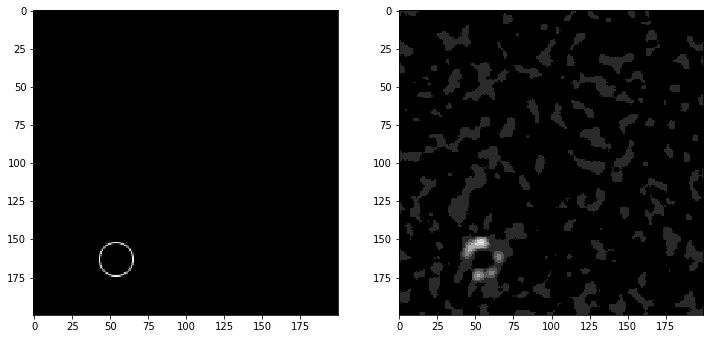

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = (image + 1) / 2
    image = np.clip(image,0,1)
    h = ax.imshow(image, cmap='gray')
    return h

transforms = Compose([ToTensor(), Normalize([0.5], [0.5])])
train_set = NoisyCircleDataset(10, transforms, preprocess=True)
x = train_set.__getitem__(8)
figs, axs = plt.subplots(1, 2, figsize=(12,8))
noisy_img = myimshow(x['clean'][0], axs[0])
clean_img = myimshow(x['noisy'][0], axs[1])


## DnCNN Model

In [40]:
class DnCNN(nn.Module):
    def __init__(self, D=3, C=32):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(1, C, 3, padding=1))
        nn.init.kaiming_normal_(self.conv[0].weight.data)
        self.bn = nn.ModuleList()
        for k in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
            nn.init.kaiming_normal_(self.conv[k+1].weight.data)
            self.bn.append(nn.BatchNorm2d(C, C))
            nn.init.constant_(self.bn[k].weight.data, 1.25*np.sqrt(C))
        self.conv.append(nn.Conv2d(C, 1, 3, padding=1))
        
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for k in range(D):
            h = self.conv[k+1](h)
            h = F.relu(self.bn[k](h))
        y = self.conv[D+1](h) + x
        return y

## Denoising Autoencoder Model

In [7]:
# define the NN architecture
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1, stride=1), 
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 8, 3, padding=1, stride=1), 
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, padding=1, stride=1), 
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Tanh()
        )
               
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Training


In [8]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight.data)
        
def train(num_epochs, batch_size, train_set, init_conv_weights=False):
    # Load loss output file
    output_file = open('output.txt', 'w')
    output_file.write('Training loss log\n')
    
    # Load and initialize the network
    net = DenoisingAutoencoder()
#     net = DnCNN(D=4, C=64)
    
    if init_conv_weights:
        net.apply(init_weights)
        
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-4)
    criterion = nn.MSELoss()
    
    # Check if your system supports CUDA
    use_cuda = torch.cuda.is_available()

    # Setup GPU optimization if CUDA is supported
    if use_cuda:
        computing_device = torch.device("cuda")
        extras = {"num_workers": 3, "pin_memory": True}
        print("CUDA is supported")
    else: # Otherwise, train on the CPU
        computing_device = torch.device("cpu")
        extras = False
        print("CUDA NOT supported")
        
    # Instantiate model to run on the GPU or CPU based on CUDA support
    net = net.to(computing_device)
    print("Model on CUDA?", next(net.parameters()).is_cuda)
      
    # Load data and create dataloader
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                                drop_last=True, pin_memory=True)
    # Begin training
    print("Start training...")
    for epoch in range(num_epochs):
        tic = time.time()
        epoch_loss = 0
        
        for idx, sample in enumerate(train_loader):
            img, target, _ = sample['noisy'], sample['clean'], sample['params']
            optimizer.zero_grad()
            y = net(img) # forward propagation
            loss = criterion(y, target) # error evaluation
            loss.backward() # backpropagation
            optimizer.step() # update parameters
             
            with torch.no_grad(): 
                epoch_loss += loss.item()
#                 if idx%10 == 0:
#                     print('Epoch {}, Batch Sample {}: Loss = {:.6f}'.format(epoch, idx, loss.item()))
            
        epoch_loss = epoch_loss / len(train_loader)
        toc = time.time()
        print('Epoch {} (Time: {:.2f}s), Epoch loss: {}'.format(epoch, toc-tic, epoch_loss))
        output_file.write('Epoch {} (Time: {:.2f}s), Epoch loss: {:.6f}\n'.format(epoch, toc-tic, epoch_loss))
    print("Training complete!")
    output_file.close()
    return y, img, target, net



## Run Training 

In [12]:
transforms = Compose([ToTensor(), Normalize([0.5], [0.5])])
train_set = NoisyCircleDataset(600, transforms, preprocess=True)
test_set = NoisyCircleDataset(1000, transforms, preprocess=True)

batch_size = 16
num_epochs = 10

denoised, noisy, clean, net = train(num_epochs, batch_size, train_set, init_conv_weights=False)


CUDA NOT supported
Model on CUDA? False
Start training...
Epoch 0 (Time: 87.85s), Epoch loss: 0.048251412292892065
Epoch 1 (Time: 75.80s), Epoch loss: 0.00896188324770412
Epoch 2 (Time: 76.83s), Epoch loss: 0.00892288241585767
Epoch 3 (Time: 89.75s), Epoch loss: 0.008926103457909179
Epoch 4 (Time: 83.38s), Epoch loss: 0.008930849767214543
Epoch 5 (Time: 72.14s), Epoch loss: 0.008952595557816126
Epoch 6 (Time: 68.17s), Epoch loss: 0.008943557902868535
Epoch 7 (Time: 66.96s), Epoch loss: 0.0089526793642624
Epoch 8 (Time: 86.17s), Epoch loss: 0.00898212575781587
Epoch 9 (Time: 76.82s), Epoch loss: 0.00896869003269318
Training complete!


predicted noisy: (42, 165, 46)
predicted denoised: (38, 163, 45)
groundtruth: (37, 164, 46)


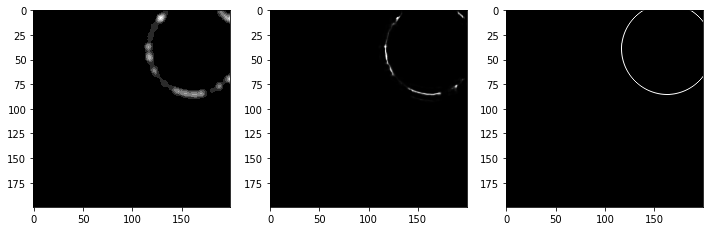

In [10]:
#--- viewing sample results from model ---#
clean = clean.detach()
noisy = noisy.detach()
denoised = denoised.detach()
sample = 1
figs, axs = plt.subplots(1, 3, figsize=(12,8))
noisy_img = myimshow(noisy[sample][0], axs[0])
denoised_img = myimshow(denoised[sample][0], axs[1])
clean_img = myimshow(clean[sample][0], axs[2])

img = noisy[sample][0].to('cpu').numpy()
print('predicted noisy:', detect_circle(normalize_range(img)))

img = denoised[sample][0].to('cpu').numpy()
print('predicted denoised:', detect_circle(normalize_range(img)))

img = clean[sample][0].to('cpu').numpy()
print('groundtruth:', detect_circle(normalize_range(img)))



## Evaluation 

In [11]:

def inference(net, test_set):
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    net.eval()
    results = []
    preds = []
    with torch.no_grad():
        for idx, sample in enumerate(test_loader):
            img, params = sample['noisy'], sample['params']
            denoised = net(img)
            denoised_img = denoised[0][0].to('cpu').numpy()
            denoised_img = normalize_range(denoised_img)
            prediction = detect_circle(denoised_img)
            preds.append((prediction, params[0]))
            groundtruth = tuple(params[0].to('cpu').numpy())
            results.append(iou(groundtruth, prediction))
    results = np.array(results)
    AP = (results > 0.7).mean()
    print('Average precision = {}'.format(AP))
    return results, preds
    
tic = time.time()
results, predictions = inference(net, train_set)
print(time.time()-tic)


Average precision = 0.0
29.907821655273438


In [17]:
tic = time.time()
inference(net, test_set)
print(time.time()-tic)



KeyboardInterrupt: 